In [ ]:
import numpy as np
import cvxpy as cp

from copy import deepcopy
from scipy.linalg import norm 

$\textbf{Задача 1}$


Для задачи линейного программирования минимизировать $$c^Tx$$ при условии $$Ax = b \texttt{ и } x \ge 0$$

\\


Сформулировать двойственную задачу и решить её

$\textbf{Решение}$

Пусть матрица $A$ состоит из $n$ строк (это $\texttt{A.shape}[0]$) и $m$ (это $\texttt{A.shape}[1]$) столбцов, тогда $b$ это столбец из $n$ строк, а $c$ и $x$ столбцы из $m$ строк.

Давайте сформулируем вначале двойственную задачу:

У нас есть ограничения $\sum\limits_{j = 1}^{j} A_{ij} x_j = b_i$, а также есть условие, что $x_i \ge 0$.

У нас каждое ограничение прямой задачи становиться переменной двойственной задачи. Поэтому у нас есть переменные $$y_1, \dots, y_n$$ 

Без ограничений (потому что изначально было равенство). Хотим максимизировать (потому что в исходной задаче минимизировали) мы 
$$\sum\limits_{i = 1}^n y_ib_i$$

Так как у нас были ограничения вида $x_i \ge 0$ для всех $i$ и мы хотели минимизировать исходное выражение, то у нас еще есть ограничения
$$\sum\limits_{i = 1}^n a_{ik}y_i \le c_i$$

Возвращаясь к матрицам, получаем, что надо минимизировать $b^Ty$ при условии $A^Ty \le c$


In [ ]:
def Solve(AA, bb): # Solves Ax = b
    A, b = deepcopy(AA), deepcopy(bb)
    cur = 0
    eps = 1e-6
    x = np.zeros(A.shape[1])
    kek = []
    for i in range(A.shape[1]):
        for j in range(cur, A.shape[0]):
            if abs(A[j][i]) > eps:
                A[j], A[cur], b[j], b[cur] = A[cur], A[j], b[cur], b[j]
                break
        if abs(A[cur][i]) > eps:
            for j in range(cur + 1, A.shape[0]):
                k = A[j][i] / A[cur][i]
                A[j] -= A[cur] * k
                b[j] -= b[cur] * k
            kek.append([cur, i])
            cur += 1
        if cur == A.shape[0]:
            break
    for i in range(cur, A.shape[0]):
        if abs(b[i]) > eps:
            raise Exception("No solution")
    for row, col in reversed(kek):
        for i in range(col + 1, A.shape[1]):
            b[row] -= x[i] * A[row][i]
        x[col] = b[row] / A[row][col]
    return x

def ConvertYToX(y, A, b, c):
    eps = 1e-6
    kek = A.T @ y - c
    indices = [i for i in range(A.shape[1]) if kek[i] > -eps]
    res = np.zeros(A.shape[1])
    res[indices] = Solve(A[:,indices], b)    
    return res

def DualProblemUsingCP(A, b, c):
    y = cp.Variable(A.shape[0])
    objective = cp.Maximize(b.T @ y)
    constraints = [A.T @ y <= c]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    return ConvertYToX(y.value, A, b, c) if y.value is not None else None

array([0. , 2.5])

In [ ]:
np.random.seed(0)

def MinimizeUsingCP(A, b, c):
    x = cp.Variable(A.shape[1])
    objective = cp.Minimize(c.T @ x)
    constraints = [x >= 0, A @ x == b]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    return x.value if x.value is not None else None

def CompareSolutions(A, b, c):
    resCorrect = MinimizeUsingCP(A, b, c)
    if resCorrect is not None:
        resMy = DualProblemUsingCP(A, b, c)
        assert(norm(resCorrect - resMy) < 1e-4)
        return True
    return False

def check(n, m, iterCount):
    cntOk = 0
    for i in range(iterCount):
        A = np.random.sample((m, n))

        b = np.random.sample(A.shape[0])
        c = np.random.sample(A.shape[1])

        if CompareSolutions(A, b, c):
            cntOk += 1

    A = np.array([[1., 2], [3., 6]])
    b = np.array([5., 15])
    c = np.array([2., 1])
    assert(CompareSolutions(A, b, c))

    print(f'ok: {cntOk}')

check(10, 3, 500)

ok: 236


$\textbf{Задача 2}$

Дан набор точек $x_1, x_2, \dots, x_m \in \mathbb{R}^n$. Требуется найти шар минимального радиуса, содержащего все эти точки.

Функция расстояния выпукла, поэтому $\texttt{dist}(p, x_i)$ выпуклые функции. Максимум из выпуклых функций это тоже выпуклая функция, поэтому $\max\limits_{i}{\texttt{dist}(p, x_i)}$ тоже выпуклая функция.А минимум выпуклой функий можно искать тернарным поиском за $O(m \log^n A)$, где $A - $ что-то типа точности с которой мы хотим найти.

In [ ]:
from copy import copy, deepcopy

def CalcVal(points, curC, resC, bestRes, curD = None, curX = None):
    if curD is not None:
        curC[curD] = curX
        if curD + 1 < points.shape[1]:
            return RunTernarySearch(points, curD + 1, curC, resC, bestRes)
    val = np.max([norm(point - curC) for point in points])
    if bestRes is None or val < bestRes:
        bestRes = val
        resC = copy(curC)
    return val, resC, bestRes

def RunTernarySearch(points, curD, curC, resC, bestRes):
    eps = 1e-2
    l = np.min(points[:,curD])
    r = np.max(points[:,curD])
    while (r - l > eps):
        m1 = (2 * l + r) / 3
        m2 = (l + 2 * r) / 3
        val1, resC, bestRes = CalcVal(points, curC, resC, bestRes, curD, m1)
        val2, resC, bestRes = CalcVal(points, curC, resC, bestRes, curD, m2)
        if val1 < val2:
            r = m2
        else:
            l = m1
    return CalcVal(points, curC, resC, bestRes, curD, l), resC, bestRes

def MinSphere(points):
    _, resC, bestRes = RunTernarySearch(points, 0, np.zeros(points.shape[1]), None, None)
    return resC, bestRes

In [ ]:
def GetСircumcircle(a, b, c):
    (ax, ay), (bx, by), (cx, cy) = a, b, c
    d = 2 * (ax * (by - cy) + bx * (cy - ay) + cx * (ay - by))
    ux = ((ax * ax + ay * ay) * (by - cy) + (bx * bx + by * by) * (cy - ay) + (cx * cx + cy * cy) * (ay - by)) / d
    uy = ((ax * ax + ay * ay) * (cx - bx) + (bx * bx + by * by) * (ax - cx) + (cx * cx + cy * cy) * (bx - ax)) / d
    c = np.array([ux, uy])
    r = norm(c - a)
    return c, r

def Check(points, centre, rad, is2D=False):
    eps = 1e-3
    for point in points:
        if np.dot(point - centre, point - centre) > rad + eps:
            return False
    if is2D:
        bestRad = None
        for i in range(len(points)):
            for j in range(i):
                for k in range(j):
                    circumcircleCentre, circumcircleRad = GetСircumcircle(points[i], points[j], points[k])
                    ok = True
                    for point in points:
                        if norm(point - circumcircleCentre) > circumcircleRad + eps:
                            ok = False
                            break
                    if ok and (bestRad is None or bestRad > circumcircleRad):
                        bestRad = circumcircleRad
        for i in range(len(points)):
            for j in range(i):
                circumcircleCentre, circumcircleRad = (points[i] + points[j]) / 2, norm((points[i] - points[j]) / 2)
                ok = True
                for point in points:
                    if norm(point - circumcircleCentre) > circumcircleRad + eps:
                        ok = False
                        break
                if ok and (bestRad is None or bestRad > circumcircleRad):
                    bestRad = circumcircleRad
        return abs(bestRad - rad) < eps
    return True

In [ ]:
np.random.seed(1)

def CheckSolution(iterCount, m, n):
    points = np.array([np.random.sample(n) for i in range(m)])
    c, r = MinSphere(points)
    if not Check(points, c, r, n == 2):
        return False
    return True

for i in range(2, 6):
    print(i, CheckSolution(1, 2 * i + 2, i))


2 True
3 True
4 True
5 True


Работает полгода почему-то на 12 точках в размерности 5 (видимо, там пятая степень дает о себе знать), но надеюсь сойдет

$\textbf{Задача 3}$

$\texttt{SVM}:$ Дан набор точек $x1, x2, \dots, x_m \in \mathbb{R}$ и пометки $y_1, y_2, \dots, y_m \in \{0, 1\}$. Требуется найти такой вектор $a$, что величина $$\max\limits_{y_i = 1}a^Tx_i - \min\limits_{y_i = 0}a^Tx_i$$ максимальна

In [ ]:
def GetA(points, marks):
    a = cp.Variable(points.shape[1])
    d1 = cp.Variable(1)
    d2 = cp.Variable(1)
    objective = cp.Maximize(d1 - d2)
    constraints = [a @ p >= d1 for i, p in enumerate(points) if marks[i] == 1] + [a @ p <= d2 for i, p in enumerate(points) if marks[i] == 0] + [cp.sum_squares(a) <= 1]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    print(d1.value, max([a.value @ p for i, p in enumerate(points) if marks[i] == 1]))
    print(d2.value, min([a.value @ p for i, p in enumerate(points) if marks[i] == 0]))
    return a.value

In [ ]:
import matplotlib.pyplot as plt

def check(m, n, iterCount):
    for iter in range(iterCount):
        a = np.random.sample(n)
        a /= norm(a)

        # print(a)
    
        points = []
        marks = []
        l = -np.random.sample(1)[0]
        r = np.random.sample(1)[0]


        for i in range(2):
            p1 = np.random.sample(n)
            if p1 @ a > 0:
                p1 *= -1
            points.append(p1 * (l / (p1 @ a)))
            marks.append(0)

        for i in range(2):
            p2 = np.random.sample(n) * 2 - 1
            if p2 @ a < 0:
                p2 *= -1
            points.append(p2 * (r / (p2 @ a)))
            marks.append(1)

        for i in range(m - 4):
            p = np.random.sample(n) * 2 - 1
            val = p @ a
            if val < 0:
                if val < l:
                    points.append(p)
                else:
                    points.append(p * (l / val + np.random.sample(1)[0]))
                marks.append(0)
            else:
                if val > r:
                    points.append(p)
                else:
                    points.append(p * (r / val + np.random.sample(1)[0]))
                marks.append(1)
        
        points = np.array(points)
        marks = np.array(marks)

        mya = GetA(points, marks)

        if n == 2:
            fig, ax = plt.subplots(figsize=[7, 7])

            x = points
            y = marks

            ax.scatter(x[y > 0,0], x[y > 0,1], color='red')
            ax.scatter(x[y == 0,0], x[y == 0,1], color='blue')

            #Level contours
            delta = 0.025
            x_ = np.arange(np.min(points[:,0]) - 1, np.max(points[:,0]) + 1, delta)
            y_ = np.arange(np.min(points[:,1]) - 1, np.max(points[:,1]) + 1, delta)
            X, Y = np.meshgrid(x_, y_)
            Z = np.zeros_like(X)
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    Z[i][j] = mya @ np.array([X[i][j], Y[i][j]])
            CS = ax.contour(X, Y, Z, [0], colors=['black'])

        assert(norm(mya - a) < 1e-2)
        

[0.43532438] 1.0347841205503059
[-0.54967225] -1.0248963863399156
[0.11314479] 1.4468218083425277
[-0.71874166] -1.4858493678362041
[0.7942526] 1.5212541364390402
[-0.82366267] -1.5362081387751236
[0.23178731] 1.4744900711114317
[-0.92559761] -1.8016191973717812
[0.65612731] 1.593836172887726
[-0.82093323] -1.6535982145054693
[0.80173795] 1.4536935034144063
[-0.57098032] -1.4208177190128044
[0.83732867] 1.7161520739799525
[-0.08142528] -1.7579037400952597
[0.35981286] 1.6418190800881196
[-0.31020448] -1.9154420327560537


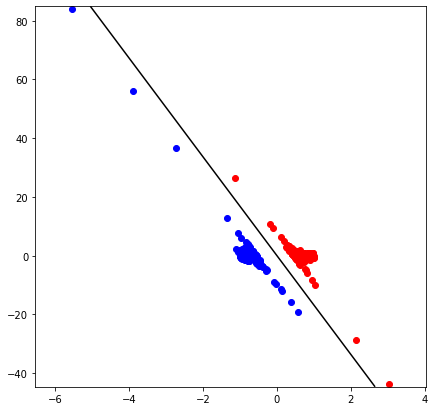

In [ ]:
np.random.seed(2)

for n in range(2, 10):
    check(500, n, 1)